# Continue a finished WorkGraph

## Introduction

`WorkGraph` supports adding new tasks to an already finished workgraph to continue the workflow. To do this, `WorkGraph` saves its data as an extra attribute of its process, so that one can rebuild the `WorkGraph` from the process.

In [1]:
%load_ext aiida
from aiida import load_profile

load_profile()

Profile<uuid='36f11577e5ee4adf9e4a5f5d62d3ae9b' name='presto'>

## Submit an `add_multiply` WorkGraph

We first create and submit a `WorkGraph` that adds two numbers and multiplies the sum by a factor.

In [2]:
from aiida_workgraph import task, WorkGraph


@task
def add(x, y):
    return x + y


@task
def multiply(x, y):
    return x * y


with WorkGraph("AddMultiply") as wg:
    sum_ = add(x=2, y=3)
    prod = multiply(x=sum_, y=6)

wg.submit(wait=True)

WorkGraph process created, PK: 8743
Process 8743 finished with state: FINISHED


<WorkGraphNode: uuid: a74a16e9-c47f-4bc3-9713-f63f12530fb4 (pk: 8743) (aiida.workflows:workgraph.engine)>

## Continue the WorkGraph with new tasks

To continue the workflow, we can load, restart, and extend the completed workgraph. We use the `load` method to load the `WorkGraph` by its `pk`, restart it, and add a second `add` task on top, linking the outputs of the previous workgraph as inputs.


In [3]:
with WorkGraph.load(wg.pk) as wg2:
    wg2.restart()
    sum_ = add(x=wg2.tasks.add.outputs.result, y=wg2.tasks.multiply.outputs.result)
    wg2.submit(wait=True)

Reset tasks: []
WorkGraph process created, PK: 8752
Process 8752 finished with state: FINISHED


### Check status and results


In [6]:
print(f"State of WorkGraph    : {wg2.state}")
print(f"Result of first add   : {wg.tasks.add.outputs.result.value}")
print(f"Result of multiply    : {wg.tasks.multiply.outputs.result.value}")
print(f"Result of second add  : {wg2.tasks.add1.outputs.result.value}")

State of WorkGraph    : FINISHED
Result of first add   : uuid: 8489c4f3-1832-4387-88c4-ba310b34c042 (pk: 8747) value: 5
Result of multiply    : uuid: ec655c18-fba6-4658-a0d6-d7e64535444a (pk: 8751) value: 30
Result of second add  : uuid: 36477fb9-d53b-4a74-8f91-694aef1f8ad4 (pk: 8756) value: 35


## The extended provenance

The full provenance remains intact, including the original workflow.

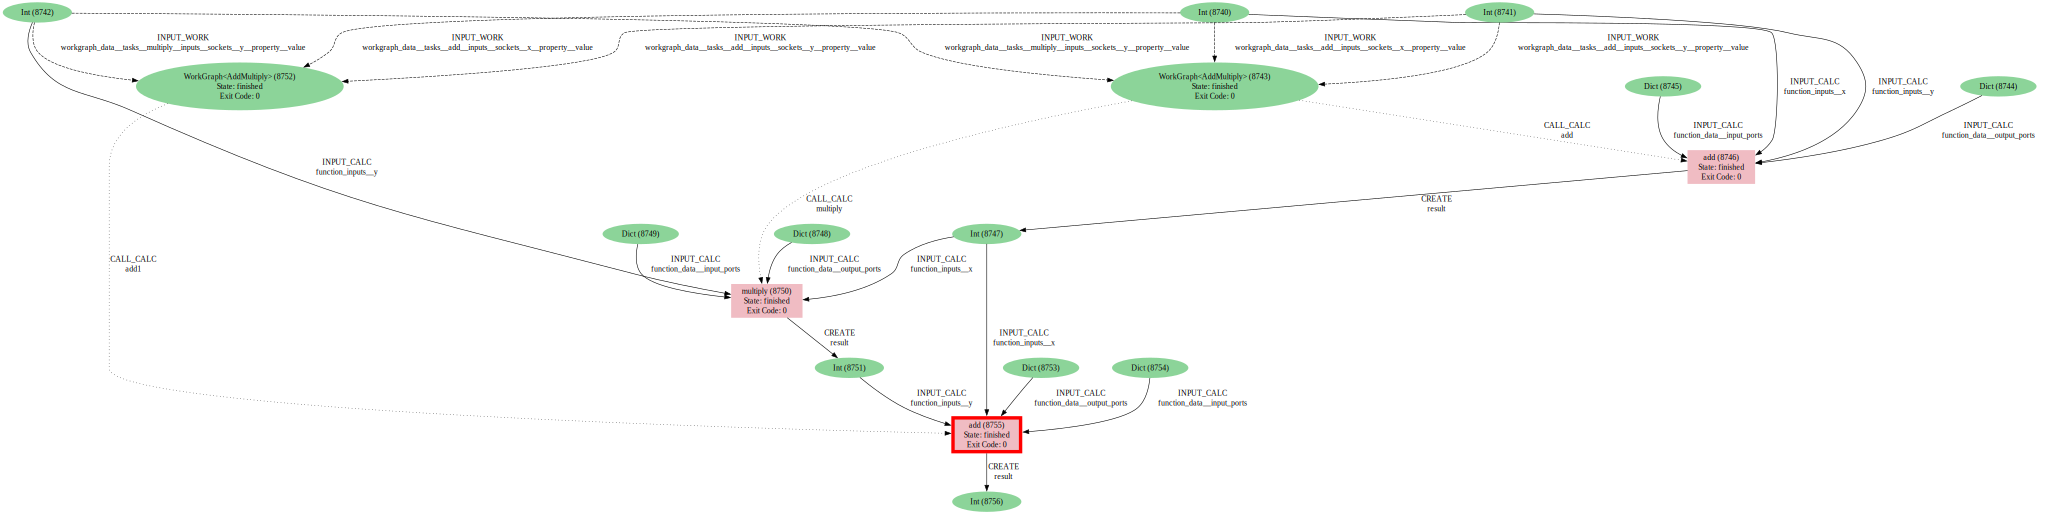

In [11]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg2.tasks["add1"].pk)

## Summary

In this section, you learned how to continue a finished `WorkGraph` by adding new tasks to a loaded, completed workgraph. This allows you to extend workflows without losing the original provenance, enabling a flexible and iterative approach to workflow management in AiiDA.